NOTE: to obtain the most recent version of this notebook, please copy from 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U3fkRu6-hwjk7wWIpg-iylL2u5T9t7rr#scrollTo=lsT4-_Eq45Ww)


## **Training rFCN Object Detection on a Custom Dataset**

### **Overview**

This notebook walks through how to train a Faster R-CNN object detection model using the TensorFlow Object Detection API.

In this specific example, we'll training an object detection model to recognize cells types: white blood cells, red blood cells and platelets. **To adapt this example to train on your own dataset, you only need to change two lines of code in this notebook.**

Everything in this notebook is also hosted on this [GitHub repo](https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn).

![Blood Cell Example](https://i.imgur.com/QwyX2aD.png)

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Data**

We'll be using an open source cell dataset called BCCD (Blood Cell Count and Detection). Our dataset contains 364 images (and 4888 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/bccd).

When adapting this example to your own data, create two datasets in Roboflow: `train` and `test`. Use Roboflow to generate TFRecords for each, replace their URLs in this notebook, and you're able to train on your own custom dataset.

### **Our Model**

We'll be training a Faster R-CNN neural network. Faster R-CNN is a two-stage detector: first it identifies regions of interest, and then passes these regions to a convolutional neural network. The outputted features maps are passed to a support vector machine (SVM) for classification. Regression between predicted bounding boxes and ground truth bounding boxes are computed. (Consider [this](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a) deep dive for more!)

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll run inference directly in this notebook, and on three test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, automate labelling quality assurance, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
global driveRoot
driveRoot = '/home/server_admin/Desktop/balaji/rFCN'
dataRoot = '/home/server_admin/Desktop/balaji'

In [ ]:
!pip install tensorflow_gpu==1.15

In [ ]:
!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Successfully uninstalled pycocotools-2.0.4
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp36-cp36m-linux_x86_64.whl size=331615 sha256=0f77732b612158d3adfe22645282ed04ad825276aab47835c9e76b909d1bc03c
  Stored in directory: /home/server_admin/.cache/pip/wheels/0c/0b/57/288a4afa870699612cfa0f61c5898d8eaf46a198e64e618d06
Successfully built pycocotools


## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 30000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'rfcn_resnet101'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
# import os

# # %cd /content

# repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
# !git clone {repo_url}
# %cd {repo_dir_path}
# !git pull

## Install required packages

In [ ]:
%cd {driveRoot}
# !git clone --quiet https://github.com/tensorflow/models.git

!sudo -S apt-get install -qq protobuf-compiler python-pil python-lxml python-tk < password.txt

!sudo -S pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools  < password.txt

!sudo -S pip install tf_slim scipy < password.txt
%cd {dataRoot}/models/research
!sudo -S protoc object_detection/protos/*.proto --python_out=. < ../../password.txt

import os
# os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
# os.environ['PYTHONPATH'] += ':/models/research/:/models/research/slim/'

%env PYTHONPATH = $dataRoot/models/research/
import os 
os.environ['PYTHONPATH'] += ":/home/server_admin/Desktop/balaji/rFCN/models/research/slim"
! echo $PYTHONPATH
# !sudo -S cp object_detection/packages/tf2/setup.py . < ../../password.txt
# !pip install .

!python object_detection/builders/model_builder_test.py

/home/server_admin/Desktop/balaji/rFCN
[sudo] password for server_admin: [sudo] password for server_admin: [sudo] password for server_admin: Requirement already satisfied: tf_slim in /usr/local/lib/python3.8/dist-packages (1.1.0)
/home/server_admin/Desktop/balaji/rFCN/models/research
[sudo] password for server_admin: env: PYTHONPATH=/home/server_admin/Desktop/balaji/rFCN/models/research/
/home/server_admin/Desktop/balaji/rFCN/models/research/:/home/server_admin/Desktop/balaji/rFCN/models/research/slim


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd {dataRoot}/tensorflow-object-detection-faster-rcnn/data

/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data


In [ ]:
# UPDATE THIS LINK - get our data from Roboflow
!curl -L https://app.roboflow.ai/ds/sgJjPlKOb7?key=KSBdLohPE5 > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    68  100    68    0     0     60      0  0:00:01  0:00:01 --:--:--    60
100   883  100   883    0     0    349      0  0:00:02  0:00:02 --:--:--   755
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0^C


In [ ]:
%ls

FYI.txt  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [ ]:
# check out what we have in train
%ls train

Gestures_label_map.pbtxt  Gestures.tfrecord


In [ ]:
# show what we have in test
%ls test

In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = dataRoot+'/tensorflow-object-detection-faster-rcnn/data/valid/Gestures.tfrecord'
train_record_fname = dataRoot+'/tensorflow-object-detection-faster-rcnn/data/train/Gestures.tfrecord'
label_map_pbtxt_fname = dataRoot+'/tensorflow-object-detection-faster-rcnn/data/train/Gestures_label_map.pbtxt'

## Download base model

In [ ]:
%cd {dataRoot}/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = driveRoot + '/pretrained_model'
# print(DOWNLOAD_BASE + MODEL_FILE)
# if not (os.path.exists(MODEL_FILE)):
#     urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# tar = tarfile.open(MODEL_FILE)
# # tar.extractall()
# tar.close()

# os.remove(MODEL_FILE)
# if (os.path.exists(DEST_DIR)):
#     shutil.rmtree(DEST_DIR)
# os.rename(MODEL, DEST_DIR)

/home/server_admin/Desktop/balaji/rFCN/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/home/server_admin/Desktop/balaji/rFCN/pretrained_model
total 476M
drwxr-xr-x 3 server_admin server_admin 4.0K Feb  2  2018 .
drwxrwxr-x 8 server_admin server_admin 4.0K Apr 19 10:01 ..
-rw-r--r-- 1 server_admin server_admin   77 Feb  2  2018 checkpoint
-rw-r--r-- 1 server_admin server_admin 208M Feb  2  2018 frozen_inference_graph.pb
-rw-r--r-- 1 server_admin server_admin 262M Feb  2  2018 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 server_admin server_admin  26K Feb  2  2018 model.ckpt.index
-rw-r--r-- 1 server_admin server_admin 6.4M Feb  2  2018 model.ckpt.meta
-rw-r--r-- 1 server_admin server_admin 3.1K Feb  2  2018 pipeline.config
drwxr-xr-x 3 server_admin server_admin 4.0K Feb  2  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/home/server_admin/Desktop/balaji/rFCN/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join(driveRoot+'/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# R-FCN with Resnet-101 (v1),  configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 7
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated

In [ ]:
model_dir = driveRoot+'/training'
# Optionally remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2022-04-18 11:47:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

                ngr   5%[>                   ] 734.66K  52.0KB/s    eta 5m 3s  ^C
Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [ ]:
!pip install tensorboard


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir {driveRoot}/training --host localhost --port 8088


## Train the model

In [ ]:
!pip install lvis

In [ ]:
!python {dataRoot}/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0419 12:30:15.402587 139866733544640 model_lib.py:839] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 30000
I0419 12:30:15.402755 139866733544640 config_util.py:552] Maybe overwriting train_steps: 30000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0419 12:30:15.402809 139866733544640 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0419 12:30:15.402852 139866733544640 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0419 12:30:15.402896 139866733544640 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0419 12:30:15.402955 139866733544640 model_lib.py:855] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1650306891.coalabserver
events.out.tfevents.1650342912.coalabserver
events.out.tfevents.1650343093.coalabserver
events.out.tfevents.1650343240.coalabserver
export
graph.pbtxt
model.ckpt-26402.data-00000-of-00001
model.ckpt-26402.index
model.ckpt-26402.meta
model.ckpt-27533.data-00000-of-00001
model.ckpt-27533.index
model.ckpt-27533.meta
model.ckpt-28665.data-00000-of-00001
model.ckpt-28665.index
model.ckpt-28665.meta
model.ckpt-29798.data-00000-of-00001
model.ckpt-29798.index
model.ckpt-29798.meta
model.ckpt-30000.data-00000-of-00001
model.ckpt-30000.index
model.ckpt-30000.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import re
import numpy as np

output_directory = driveRoot + '/fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python {dataRoot}/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

/home/server_admin/Desktop/balaji/rFCN/training/model.ckpt-30000
INFO:tensorflow:Scale of 0 disables regularizer.
I0419 10:01:45.446280 140238424741056 regularizers.py:99] Scale of 0 disables regularizer.
Instructions for updating:
Please use `layer.__call__` method instead.
W0419 10:01:45.448321 140238424741056 deprecation.py:323] From /home/server_admin/anaconda3/envs/kvb/lib/python3.6/site-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0419 10:01:47.601303 140238424741056 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0419 10:01:47.696935 140238424741056 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0419 10:01:47.697194 1402384247

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-rw-r-- 1 server_admin server_admin 191M Apr 19 10:01 /home/server_admin/Desktop/balaji/rFCN/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
!pip install google-colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

To test on your own images, you need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


#### Add test images to this notebook

We can download the exact same raw images that are in our Roboflow test split to our local computer by downloading the images in a different (non-TFRecord) format.

Go back to our [dataset](https://public.roboflow.ai/object-detection/bccd/1), click "Download," select "COCO JSON" as the format, and download to your local machine.

Unzip the downloaded file, and navigate to the `test` directory.
![folder](https://i.imgur.com/xkjxmKP.png)


Now, on the left-hand side in the colab notebook, select the folder icon.
![Colab folder](https://i.imgur.com/59v08qG.png)

Right-click on `test`, and select "Upload." Navigate to the files locally on your machine you just downloaded...and voila! You're set!


In [ ]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
repo_dir_path = dataRoot+'/tensorflow-object-detection-faster-rcnn/'
%cd {repo_dir_path}
%cd data/test
%rm Gestures.tfrecord
%rm Gestures_label_map.pbtxt

/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn
/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test
rm: cannot remove 'Gestures.tfrecord': No such file or directory
rm: cannot remove 'Gestures_label_map.pbtxt': No such file or directory


In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test")

TEST_IMAGE_PATHS = PATH_TO_TEST_IMAGES_DIR 

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
if len(TEST_IMAGE_PATHS) == 0:
  sample_img = 'https://storage.googleapis.com/roboflow-platform-transforms/Ly2DeBzbwsemGd2ReHk4BFxy8683/cf5ed147e4f2675fbabbc9b0db750ecf/transformed.jpg'
  import urllib.request
  urllib.request.urlretrieve(sample_img, 
                            PATH_TO_TEST_IMAGES_DIR + "/cell.jpg")

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/clear-052_jpg.rf.26b475700ad14f911e667cf21b585089.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/fixPos-101_jpg.rf.222bdec69e76ee54aa799e043312a718.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/clear-248_jpg.rf.d17e1c0208df4e600839f25b2cb4154f.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/zoomOut-020_jpg.rf.2da437ed8aba25d9b701f2b5ecb67baa.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/rotateX-143_jpg.rf.0a9d7d52af964eefdfcc894ce5302300.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/zoomIn-133_jpg.rf.2fc40c0a7d5301f74353185b2e826040.jpg', '/home/server_admin/Desktop/balaji/rFCN/tensorflow-object-detection-faster-rcnn/data/test/fixPos-206_jpg.rf.1abb34b6f

In [ ]:
!pip install matplotlib
!pip install matplotlib-inline

In [ ]:
%cd {dataRoot}/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/home/server_admin/Desktop/balaji/rFCN/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

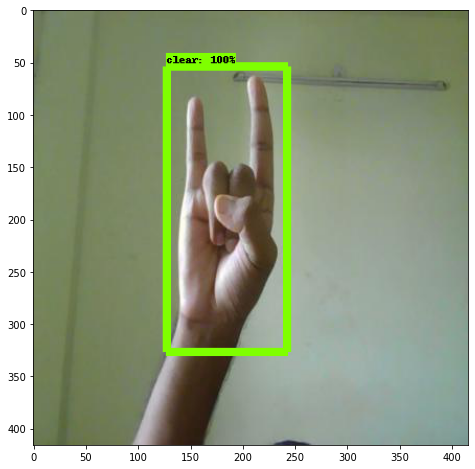

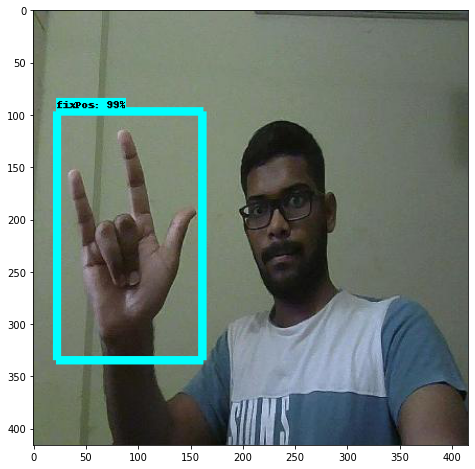

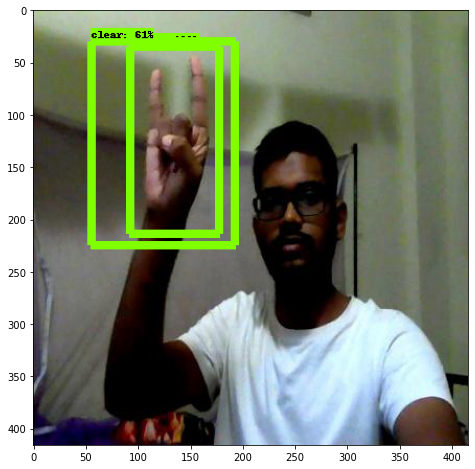

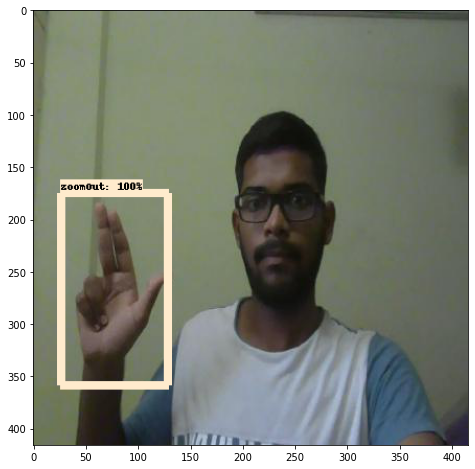

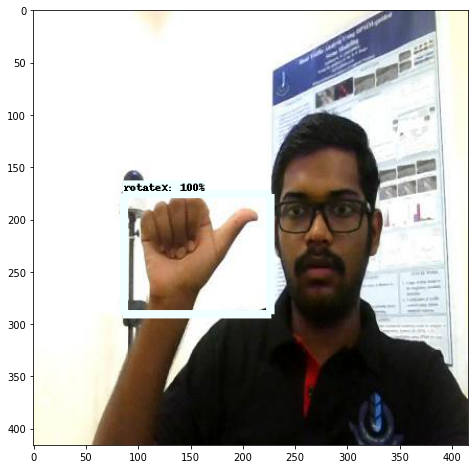

In [ ]:


count = 0
for image_path in TEST_IMAGE_PATHS:
    if count == 5:
      break
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    count += 1